# Mapping Geotagged Street-view Images to Crop Maps
#### Hanxi Li, CSISS, GMU, hli51@gmu.edu

Welcome to the Crop Mapping Workflow Notebook, which contains the complete implementation of the pipeline for mapping crop fields using geotagged street-view images. The workflow is designed to test the feasibility of using geotagged street-view images to create accurate crop maps when crop type labels are predetermined.

This notebook guides you through the essential steps, including pre-processing geotagged metadata, retrieving satellite imagery, generating field boundaries, and mapping crop fields.

In [1]:
# %load_ext autoreload
# %autoreload 2
import os
import sys
sys.path.append("/Users/steeeve/Documents/GMU/GGS590/Final_Project")

os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import torch 
import ee
import pandas as pd
from MappingCropField import extract_metadata, generate_delineation, display_assigned_field

In [2]:
# Ensure the newest version is installed
# Since the parameter pattern changed for osmnx on 2.0.0
%pip install --upgrade pyproj osmnx --quiet 

Note: you may need to restart the kernel to use updated packages.


##### Config

In [3]:
config = {"all_img_path": "/Users/steeeve/Documents/GMU/GGS590/Final_Project/data/all_sv_imgs",
          "color_composite": "true_color", # Pick between true_color and false_color
          "save_path": "/Users/steeeve/Documents/GMU/GGS590/Final_Project/sent2/",
          "credential_path": "/Users/steeeve/Documents/GMU/GGS590/Final_Project/hanxli_creds.json",
          "label_csv_path": "/Users/steeeve/Documents/GMU/GGS590/Final_Project/data/csiss_imgs.csv",
          "folder_id": "1iwSPV5D05rA9T2TdQ9gy9ED5UDimLpNA" # Folder ID from Google Drive Folder Address
          }

##### Extracting Metadata from Geotagged Images

In [4]:
meta_df = extract_metadata(config["all_img_path"])
meta_df.head(3)

,filename,img_path,altitude,direction,time,geometry
0,IMG_2022_176.jpg,../data/all_sv_imgs/IMG_2022_176.jpg,420.764783,91.784451,2022:08:09 15:20:29,POINT (-96.614 40.697)
1,IMG_2023_365.jpg,../data/all_sv_imgs/IMG_2023_365.jpg,622.166723,248.346314,2023:10:14 14:08:05,POINT (-98.769 40.771)
2,IMG_2023_403.jpg,../data/all_sv_imgs/IMG_2023_403.jpg,337.280145,183.725876,2023:10:15 11:12:46,POINT (-96.18 40.473)


In [5]:
label_df = pd.read_csv(config["label_csv_path"], index_col=0)
label_df.head(3)

,img_name,timestamp,crop_type,save_path,geometry
0,IMG_2022_001.jpg,2022-08-09 13:54:08,Maize,/home/hanxli/data/data/all_sv_imgs/IMG_2022_00...,POINT (-134842.93178947328 1983715.3378369794)
1,IMG_2022_003.jpg,2022-08-09 13:54:20,Soybean,/home/hanxli/data/data/all_sv_imgs/IMG_2022_00...,POINT (-134401.7644465734 1983428.4774710557)
2,IMG_2022_004.jpg,2022-08-09 14:48:06,Soybean,/home/hanxli/data/data/all_sv_imgs/IMG_2022_00...,POINT (-134291.47027611607 1983356.61060757)


In [6]:
label_subset = label_df[["img_name", "crop_type"]]

# Merge df1 with the subset of df2 based on filename (df1) and img_name (df2)
meta_df = pd.merge(meta_df, label_subset, left_on="filename", right_on="img_name", how="left", suffixes=("_meta", "_label"))

# Drop the redundant img_name column
meta_df = meta_df.drop(columns=["img_name"])

# Display the updated DataFrame
meta_df = meta_df.dropna(subset=["crop_type"]).reset_index(drop=True)
meta_df.head(3)

,filename,img_path,altitude,direction,time,geometry,crop_type
0,IMG_2023_365.jpg,../data/all_sv_imgs/IMG_2023_365.jpg,622.166723,248.346314,2023:10:14 14:08:05,POINT (-98.769 40.771),Maize
1,IMG_2023_403.jpg,../data/all_sv_imgs/IMG_2023_403.jpg,337.280145,183.725876,2023:10:15 11:12:46,POINT (-96.18 40.473),Maize
2,IMG_2023_417.jpg,../data/all_sv_imgs/IMG_2023_417.jpg,361.880265,188.567879,2023:10:15 11:23:28,POINT (-96.18 40.315),Other


##### Spatial processing

In [7]:
ee.Authenticate()
ee.Initialize(project="ee-hanxli")

In [ ]:
generate_delineation(meta_df[0:1], 
                     color_composite = config["color_composite"], 
                     save_path = config["save_path"],
                     credentials_file_path = config["credential_path"],
                     folder_id = config["folder_id"],
                     visualize = True)

In [ ]:
# Randomly select 20 rows from meta_df
meta_subset = meta_df.sample(n=20, random_state=42).reset_index(drop=True)
lbl_bounds = display_assigned_field(meta_subset,
                                    color_composite = config["color_composite"], 
                                    save_path = config["save_path"],
                                    credentials_file_path = config["credential_path"],
                                    folder_id = config["folder_id"],
                                    batch_process=True)

In [9]:
lbl_bounds

,filename,time,crop_type,geometry
0,IMG_2023_113.jpg,2023:10:13 17:36:43,Maize,"POLYGON ((6.84e+05 4.64e+06, 6.84e+05 4.64e+06..."
1,IMG_2022_340.jpg,2022:08:11 11:31:47,Soybean,"POLYGON ((3.31e+05 4.57e+06, 3.31e+05 4.57e+06..."
2,IMG_2023_316.jpg,2023:10:14 11:24:52,Maize,"POLYGON ((6.37e+05 4.56e+06, 6.37e+05 4.56e+06..."
3,IMG_2023_199.jpg,2023:10:14 11:02:54,Maize,"POLYGON ((6.74e+05 4.56e+06, 6.74e+05 4.56e+06..."
4,IMG_2023_446.jpg,2023:10:15 11:35:45,Soybean,"POLYGON ((7.4e+05 4.46e+06, 7.4e+05 4.46e+06, ..."
5,IMG_2022_035.jpg,2022:08:09 14:09:13,Maize,"POLYGON ((6.18e+05 4.5e+06, 6.18e+05 4.5e+06, ..."
6,IMG_2023_226.jpg,2023:10:14 11:04:26,Soybean,"POLYGON ((6.71e+05 4.56e+06, 6.71e+05 4.56e+06..."
7,IMG_2023_089.jpg,2023:10:13 17:24:15,Maize,"POLYGON ((6.7e+05 4.65e+06, 6.7e+05 4.65e+06, ..."
8,IMG_2023_284.jpg,2023:10:14 11:12:27,Soybean,"POLYGON ((6.57e+05 4.56e+06, 6.57e+05 4.56e+06..."
9,IMG_2023_557.jpg,2023:10:15 18:31:24,Other,"POLYGON ((7.27e+05 4.57e+06, 7.27e+05 4.57e+06..."


##### Validation

In [ ]:
# Simple combine of all groundtruth
import geopandas as gpd
import matplotlib.pyplot as plt
gdf1 = lbl_bounds
gdf2 = gpd.read_file("/Users/steeeve/Documents/GMU/GGS590/Final_Project/data/In-season 2023 ground truth/Nebraska2023groundtruth.shp")
gdf3 = gpd.read_file("/Users/steeeve/Documents/GMU/GGS590/Final_Project/data/IowaNebraska2022_GroundTruthShp/GroundTruthNebraska2022.shp")
gdf4 = gpd.read_file("/Users/steeeve/Documents/GMU/GGS590/Final_Project/data/IowaNebraska2022_GroundTruthShp/GroundTruthIowa2022.shp")
gdf5 = gpd.read_file("/Users/steeeve/Documents/GMU/GGS590/Final_Project/data/IowaNebraska2022_GroundTruthShp/GroundTruthMaryland2022.shp")
target_crs = gdf1.crs
gdf2 = gdf2.to_crs(target_crs)
gdf3 = gdf3.to_crs(target_crs)
gdf4 = gdf4.to_crs(target_crs)
gdf5 = gdf5.to_crs(target_crs)
merged_gdf = gpd.GeoDataFrame(pd.concat([gdf2, gdf3], ignore_index=True))
merged_gdf = gpd.GeoDataFrame(pd.concat([merged_gdf, gdf4], ignore_index=True))
merged_gdf = gpd.GeoDataFrame(pd.concat([merged_gdf, gdf5], ignore_index=True))

Total geometries in gdf1: 10
Intersecting geometries: 7
Intersection Accuracy: 70.00%


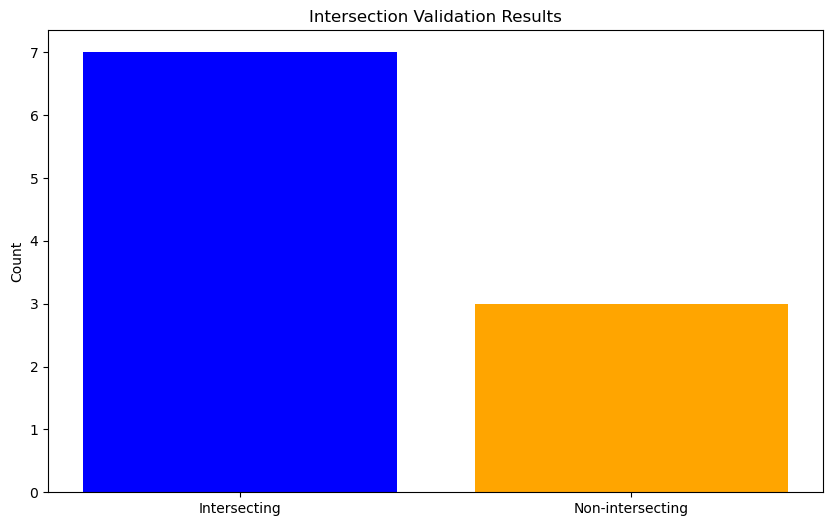

In [18]:
gdf1 = lbl_bounds
gdf2 = merged_gdf

if gdf1.crs != gdf2.crs:
    gdf2 = gdf2.to_crs(gdf1.crs)

# Check intersections and add a validation column
gdf1['intersects'] = gdf1.geometry.apply(lambda geom: gdf2.geometry.intersects(geom).any())

# Calculate metrics
total_geometries = len(gdf1)
intersecting_geometries = gdf1['intersects'].sum()
intersection_accuracy = intersecting_geometries / total_geometries

# Print summary
print(f"Total geometries in gdf1: {total_geometries}")
print(f"Intersecting geometries: {intersecting_geometries}")
print(f"Intersection Accuracy: {intersection_accuracy:.2%}")

# Plot results
plt.figure(figsize=(10, 6))
plt.bar(["Intersecting", "Non-intersecting"], [intersecting_geometries, total_geometries - intersecting_geometries], color=["blue", "orange"])
plt.title("Intersection Validation Results")
plt.ylabel("Count")
plt.show()


In [19]:
gdf1

,filename,time,crop_type,geometry,overlaps,intersects
0,IMG_2023_113.jpg,2023:10:13 17:36:43,Maize,"POLYGON ((6.84e+05 4.64e+06, 6.84e+05 4.64e+06...",False,True
1,IMG_2022_340.jpg,2022:08:11 11:31:47,Soybean,"POLYGON ((3.31e+05 4.57e+06, 3.31e+05 4.57e+06...",False,False
2,IMG_2023_316.jpg,2023:10:14 11:24:52,Maize,"POLYGON ((6.37e+05 4.56e+06, 6.37e+05 4.56e+06...",False,False
3,IMG_2023_199.jpg,2023:10:14 11:02:54,Maize,"POLYGON ((6.74e+05 4.56e+06, 6.74e+05 4.56e+06...",False,True
4,IMG_2023_446.jpg,2023:10:15 11:35:45,Soybean,"POLYGON ((7.4e+05 4.46e+06, 7.4e+05 4.46e+06, ...",False,True
5,IMG_2022_035.jpg,2022:08:09 14:09:13,Maize,"POLYGON ((6.18e+05 4.5e+06, 6.18e+05 4.5e+06, ...",False,True
6,IMG_2023_226.jpg,2023:10:14 11:04:26,Soybean,"POLYGON ((6.71e+05 4.56e+06, 6.71e+05 4.56e+06...",False,True
7,IMG_2023_089.jpg,2023:10:13 17:24:15,Maize,"POLYGON ((6.7e+05 4.65e+06, 6.7e+05 4.65e+06, ...",False,False
8,IMG_2023_284.jpg,2023:10:14 11:12:27,Soybean,"POLYGON ((6.57e+05 4.56e+06, 6.57e+05 4.56e+06...",False,True
9,IMG_2023_557.jpg,2023:10:15 18:31:24,Other,"POLYGON ((7.27e+05 4.57e+06, 7.27e+05 4.57e+06...",False,True
